# SmartBeds - Visualización de constantes vitales

## Grado en Ingeniería Informática
## Universidad de Burgos
##### José Luis Garrido Labrador

In [1]:
import pandas as pd # se importa pandas como pd
import numpy as np  #numpy como np
import matplotlib.pyplot as plt
import sys
import pickle as pk

## Carga de los datos

In [2]:
import loadData as ld

datos = ld.load(r"../data/")
datos = ld.constantesVitales(datos)
datos.head()

,DateTime,HR,RR,SV,HRV,B2B,target
1,2018-09-14 21:04:18,0.0,0.0,0.0,0.0,0.0,False
4,2018-09-14 21:04:21,0.0,0.0,0.0,0.0,0.0,False
7,2018-09-14 21:04:24,0.0,0.0,0.0,0.0,0.0,False
8,2018-09-14 21:04:25,0.0,0.0,0.0,0.0,0.0,False
9,2018-09-14 21:04:26,0.0,0.0,0.0,0.0,0.0,False


In [3]:
datos = ld.newSeizure(datos,'2019-01-29 6:12:00',60*15)

In [4]:
datos = datos.sort_values(by='DateTime')
# Se considera el inicio de los datos como '2019-01-23 00:00:00'
cond = datos['DateTime'] >= pd.to_datetime('2019-01-23 00:00:00')
datos = datos[cond]
datos.head()
with open('data/datos_vitales.pdd','wb') as f:
    pk.dump(datos,f)
datos.head()

,DateTime,HR,RR,SV,HRV,B2B,target
1860350,2019-01-23 21:15:37,0.0,0.0,0.0,0.0,0.0,False
1860351,2019-01-23 21:15:38,0.0,0.0,0.0,0.0,0.0,False
1860352,2019-01-23 21:15:38,0.0,0.0,0.0,0.0,0.0,False
1860353,2019-01-23 21:15:39,0.0,0.0,0.0,0.0,0.0,False
1860354,2019-01-23 21:15:40,0.0,0.0,0.0,0.0,0.0,False


Text(0.5, 1.0, 'B2B')

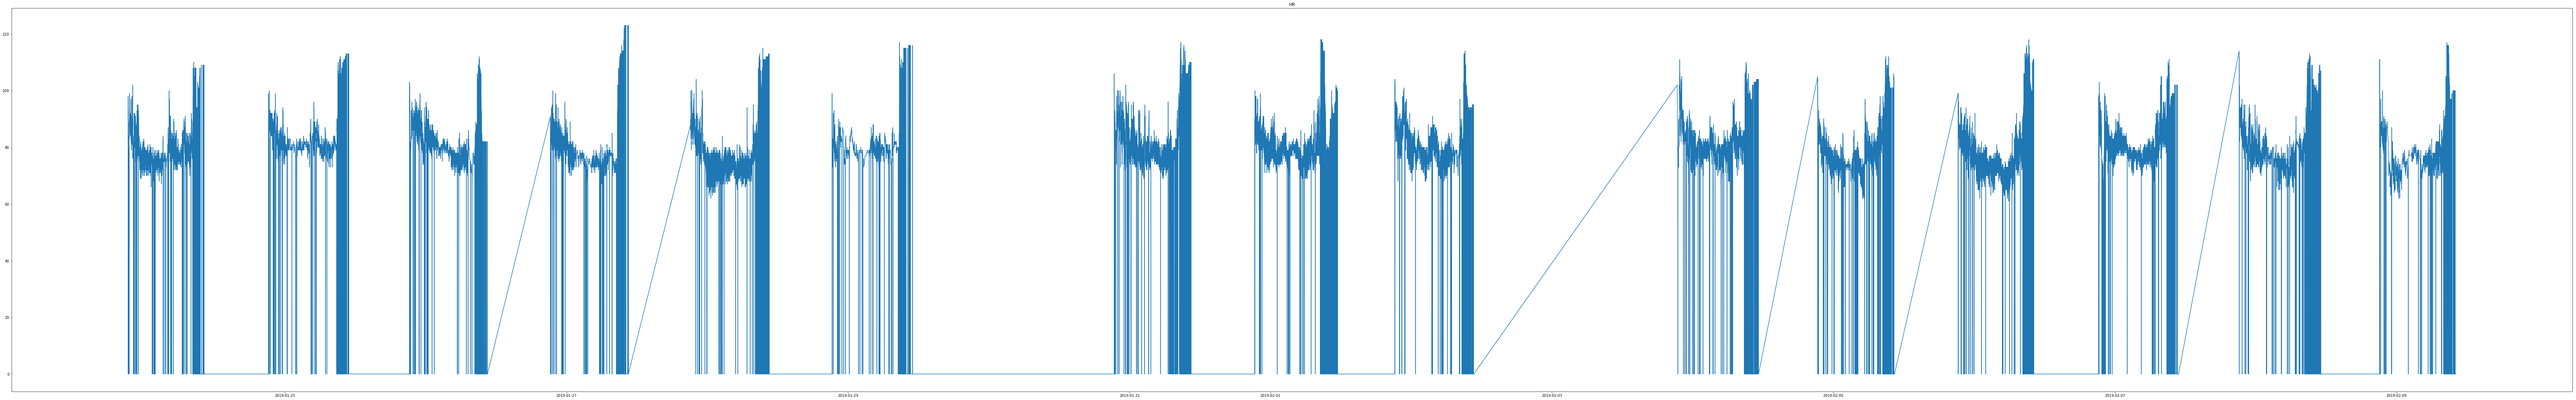

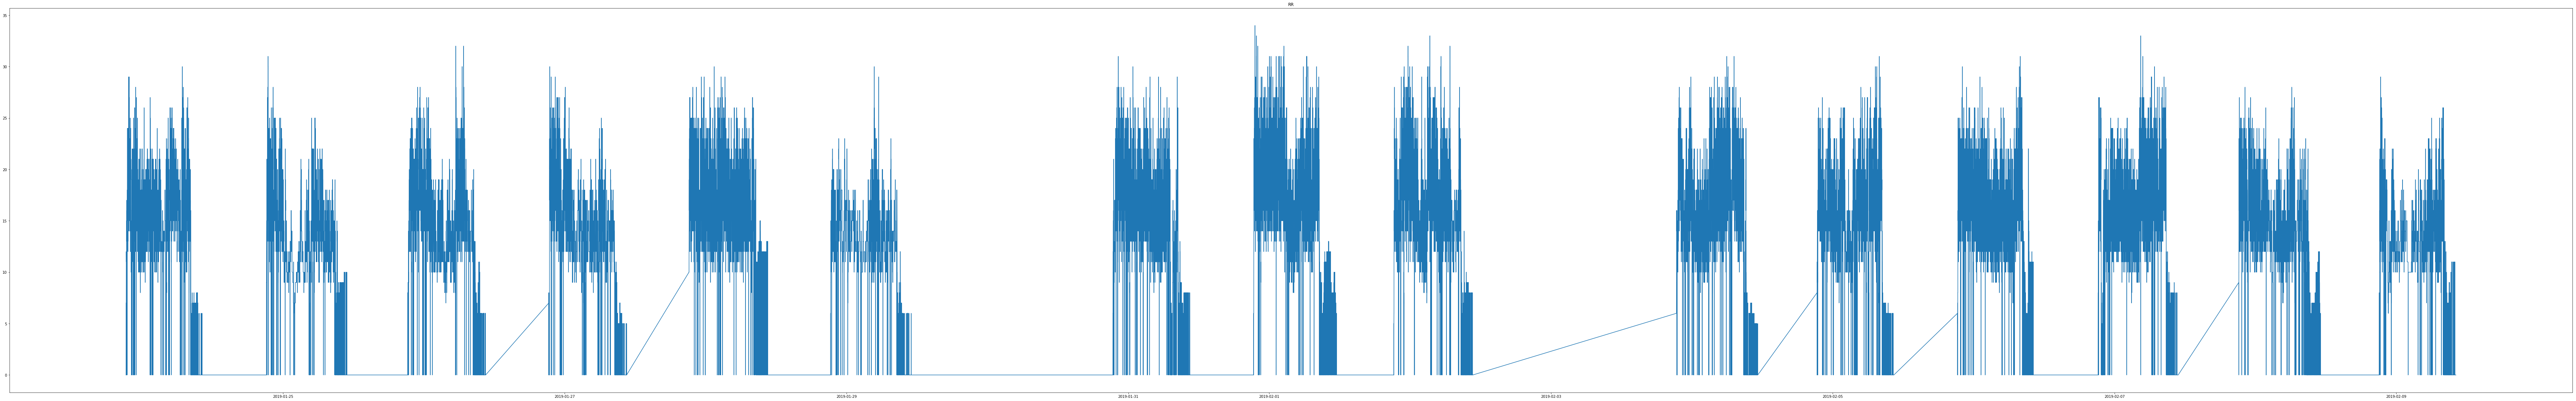

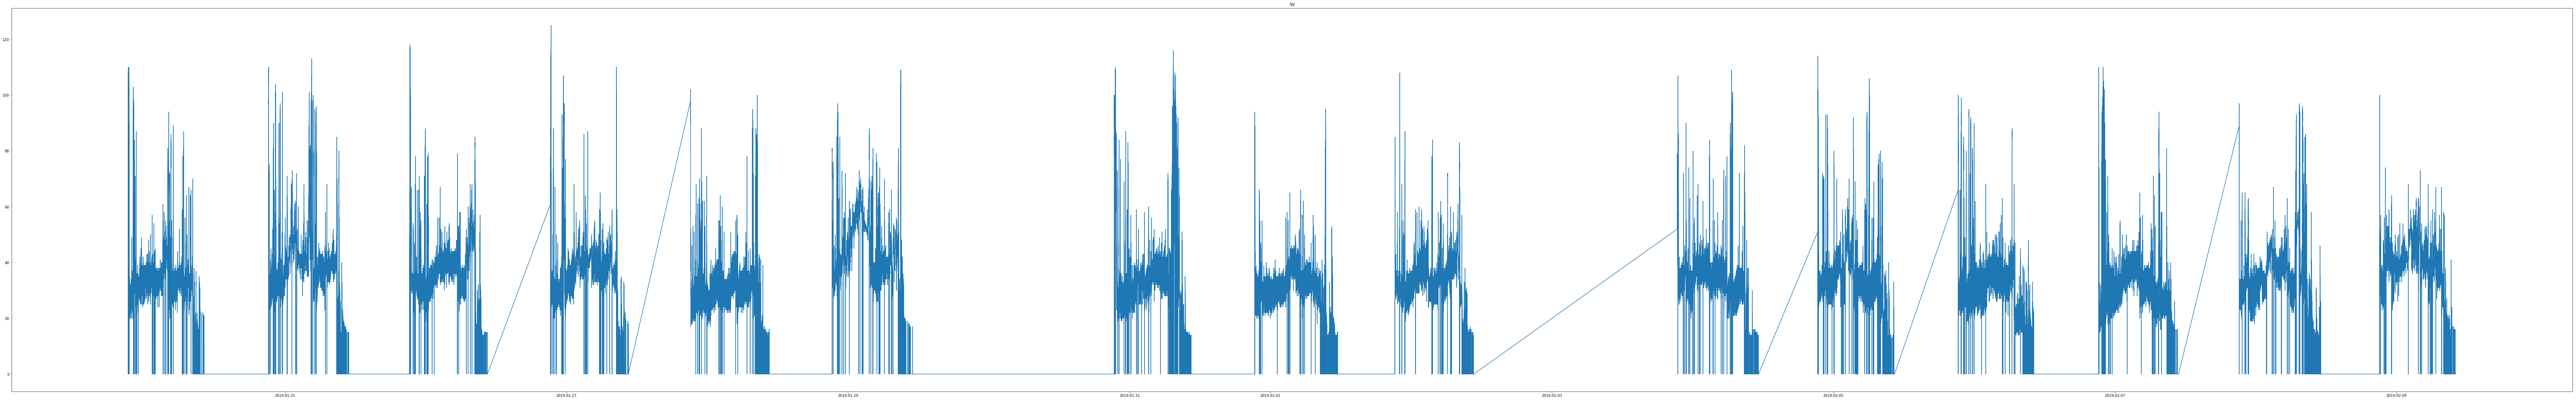

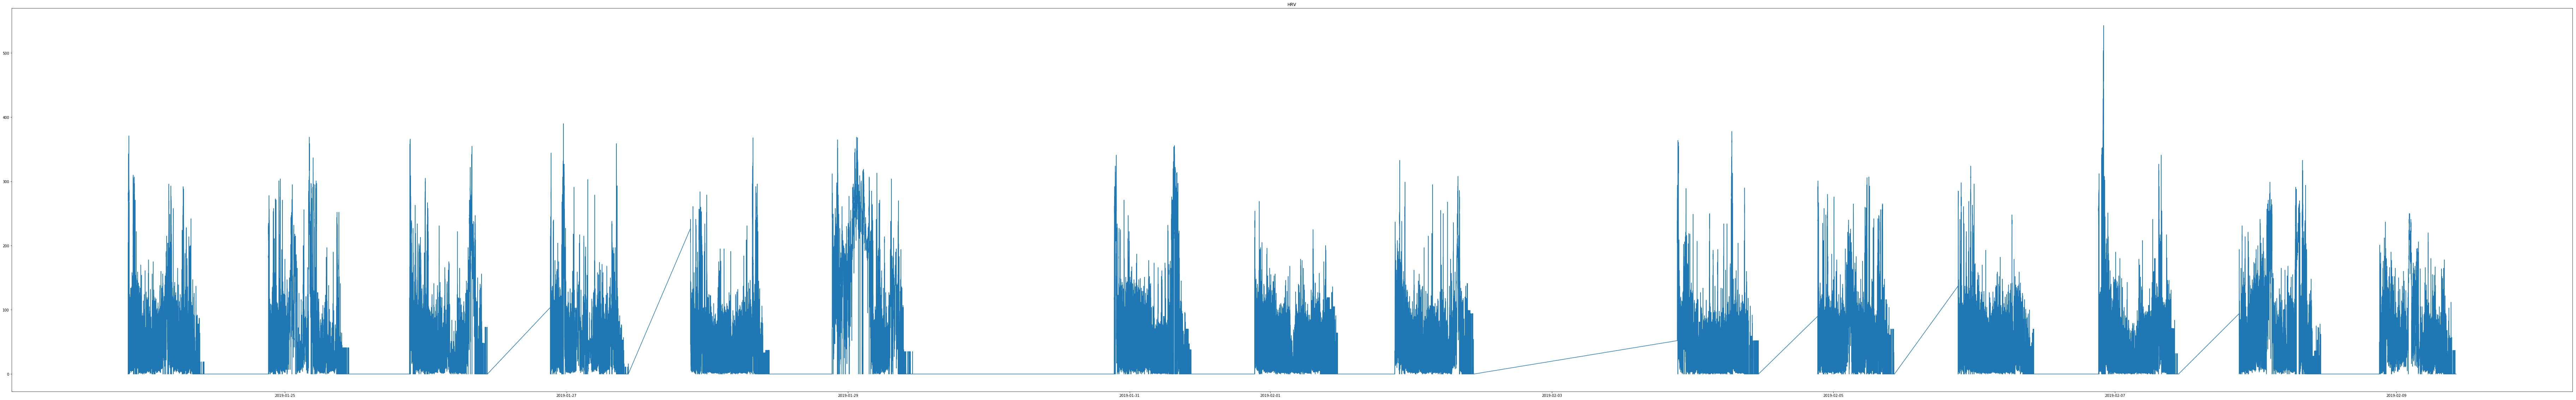

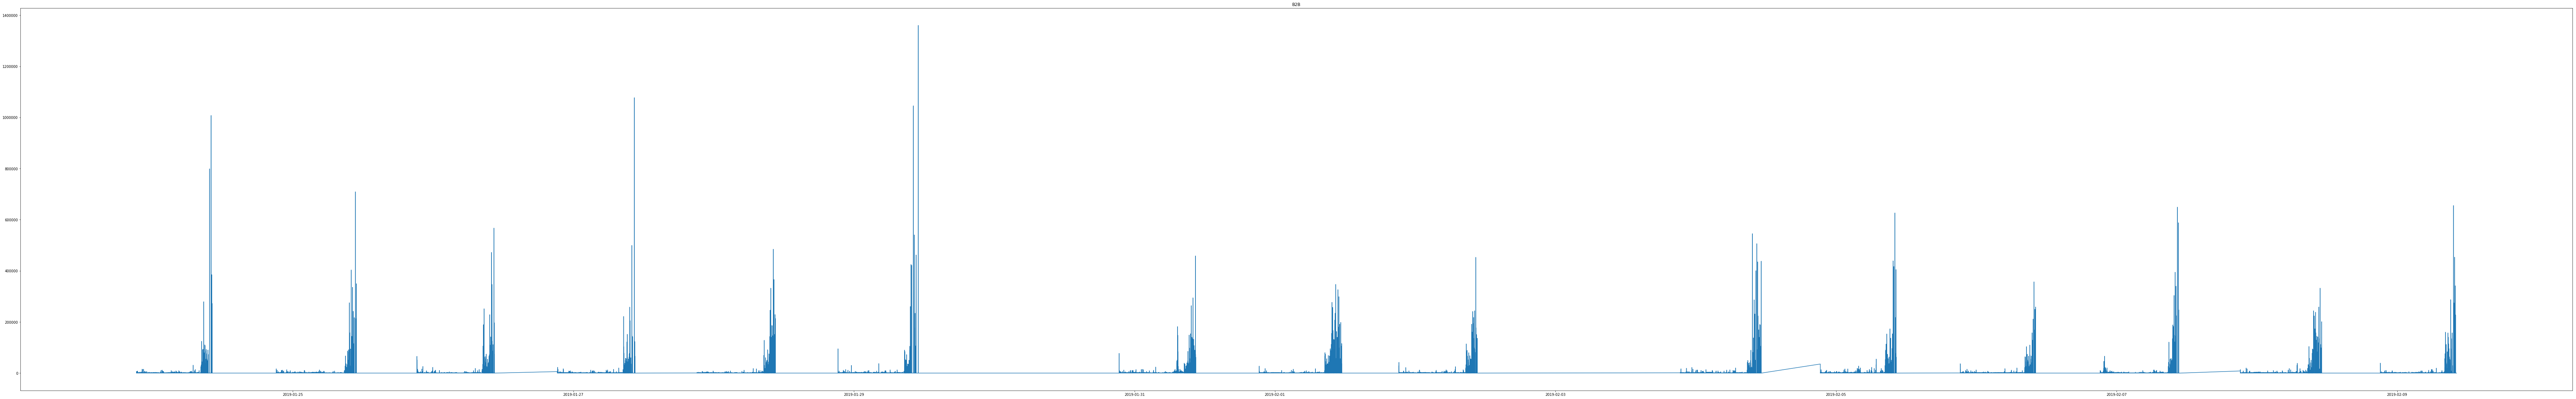

In [5]:
plt.figure(figsize=(130,20))
plt.plot(datos.DateTime,datos.HR)
plt.title('HR')
plt.figure(figsize=(130,20))
plt.plot(datos.DateTime,datos.RR)
plt.title('RR')
plt.figure(figsize=(130,20))
plt.plot(datos.DateTime,datos.SV)
plt.title('SV')
plt.figure(figsize=(130,20))
plt.plot(datos.DateTime,datos.HRV)
plt.title('HRV')
plt.figure(figsize=(130,20))
plt.plot(datos.DateTime,datos.B2B)
plt.title('B2B')

### Preprocesamiento
Se normalizan los datos por columna entre 0 y 1

In [7]:
from transformers import EachNormalizer

In [8]:
datosNorm = EachNormalizer().fit_transform(datos[["HR","RR","SV","HRV","B2B"]])
datosNorm.head()

,HR,RR,SV,HRV,B2B
1860350,0.0,0.0,0.0,0.0,0.0
1860351,0.0,0.0,0.0,0.0,0.0
1860352,0.0,0.0,0.0,0.0,0.0
1860353,0.0,0.0,0.0,0.0,0.0
1860354,0.0,0.0,0.0,0.0,0.0


In [11]:
datos_pre = pd.concat((datos[['DateTime']],datosNorm,datos[['target']]),axis=1)
datos_pre.head()

,DateTime,HR,RR,SV,HRV,B2B,target
1860350,2019-01-23 21:15:37,0.0,0.0,0.0,0.0,0.0,False
1860351,2019-01-23 21:15:38,0.0,0.0,0.0,0.0,0.0,False
1860352,2019-01-23 21:15:38,0.0,0.0,0.0,0.0,0.0,False
1860353,2019-01-23 21:15:39,0.0,0.0,0.0,0.0,0.0,False
1860354,2019-01-23 21:15:40,0.0,0.0,0.0,0.0,0.0,False


### Separación por días

In [13]:
inicios = list()
finales = list()

anterior = pd.to_datetime('1970-01-01 00:00:00')
margen = pd.to_timedelta(1,unit='h')
for index,dl in datos_pre.iterrows():
    hora = dl['DateTime']
    diff = hora-anterior
    if diff >= margen:
        if len(inicios)>len(finales): #Primera vuelta no introduce la fecha anterior
            finales.append(anterior)
        inicios.append(hora)
    anterior = hora
    
finales.append(pd.Timestamp.now())

In [15]:
trozos = []
for i in range(len(inicios)):
    ini = inicios[i]
    fin = finales[i]
    mask = (datos_pre['DateTime'] >= ini) & (datos_pre['DateTime'] <= fin)
    trozos.append(datos_pre.loc[mask])

In [17]:
len(trozos)

15

In [18]:
with open('data/constantes_trozos.pkl','wb') as f:
    pk.dump(trozos,f)

### Visualización del día de la crisis
Se encuentra en el trozo 6

In [32]:
dia_crisis = trozos[5]
crisis = dia_crisis[dia_crisis['target']==True]
start = crisis.iloc[0].DateTime
end = crisis.iloc[-1].DateTime

no_crisis = dia_crisis[dia_crisis['target']==False]
antes = no_crisis.DateTime < start
despues = no_crisis.DateTime > end
no_crisis_antes = no_crisis[antes]
no_crisis_despues = no_crisis[despues]
crisis.head()

,DateTime,HR,RR,SV,HRV,B2B,target
7011303,2019-01-29 06:12:00,0.626016,0.323529,0.312,0.034991,0.000561,True
7011305,2019-01-29 06:12:00,0.626016,0.323529,0.312,0.034991,0.000561,True
7011304,2019-01-29 06:12:00,0.626016,0.323529,0.312,0.034991,0.000561,True
7011306,2019-01-29 06:12:01,0.626016,0.323529,0.312,0.034991,0.000533,True
7011307,2019-01-29 06:12:01,0.626016,0.323529,0.312,0.034991,0.000533,True


Text(0.5, 1.0, 'B2B')

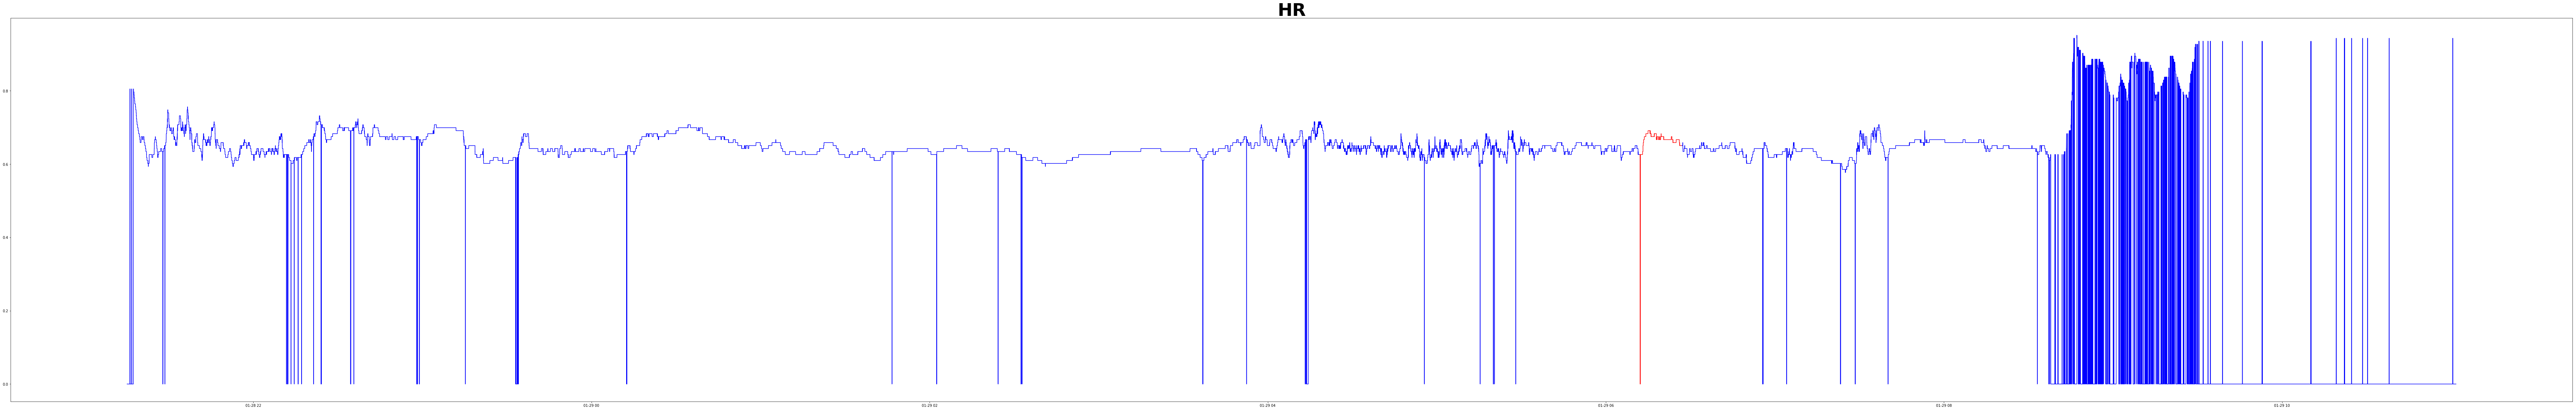

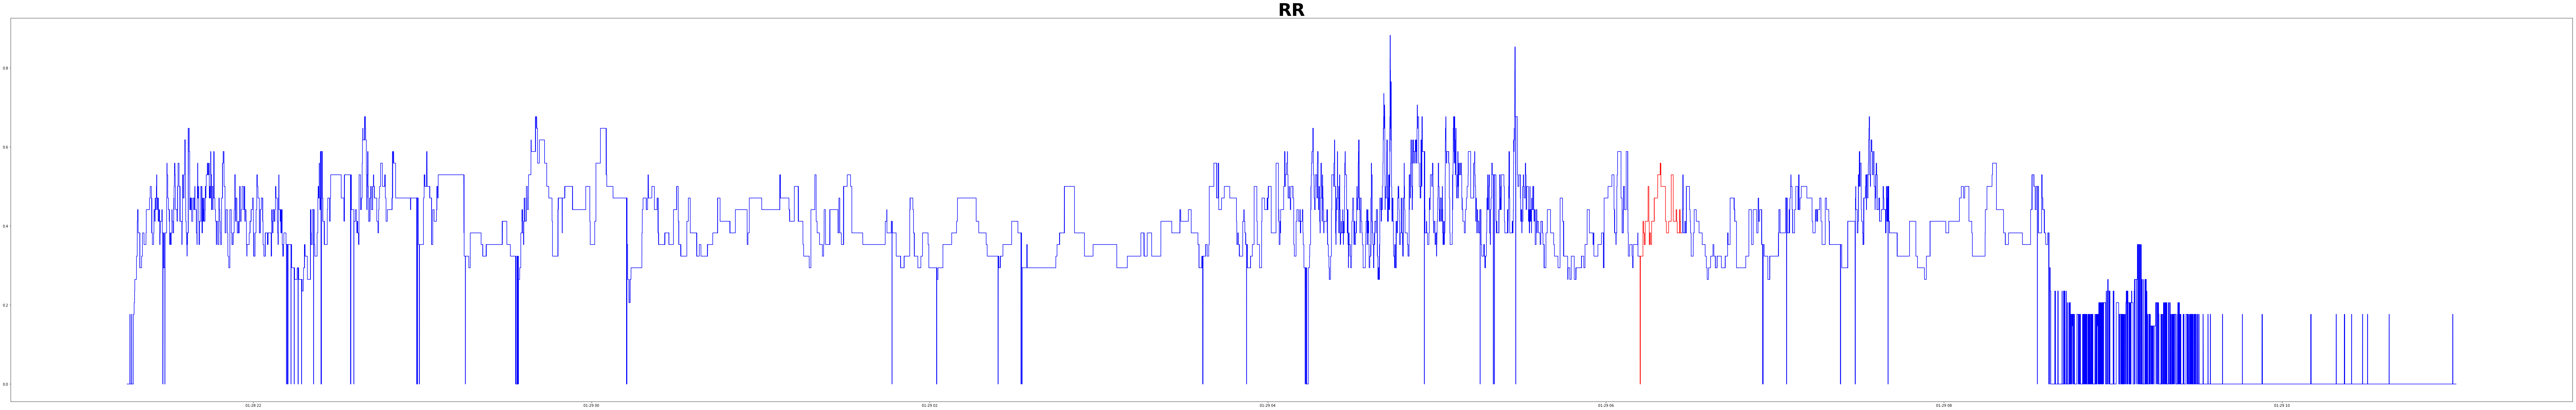

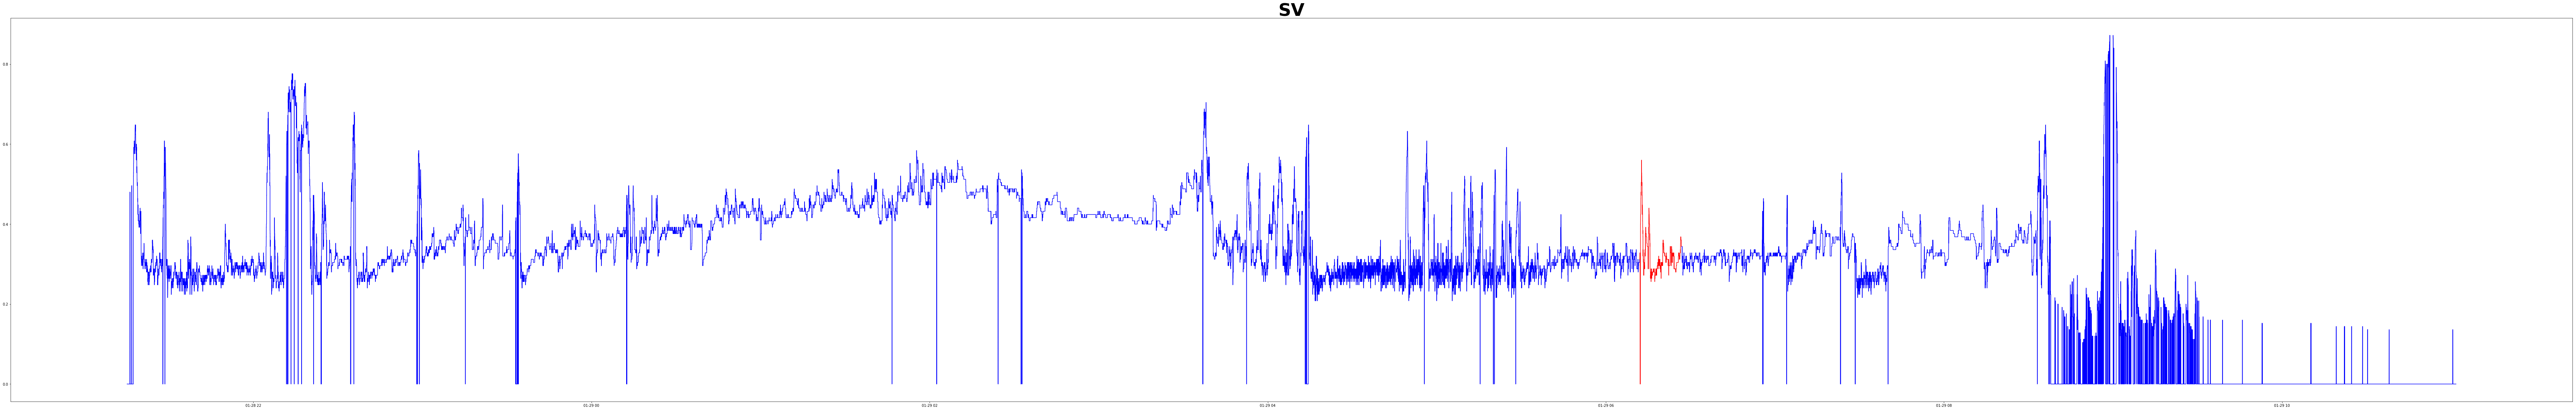

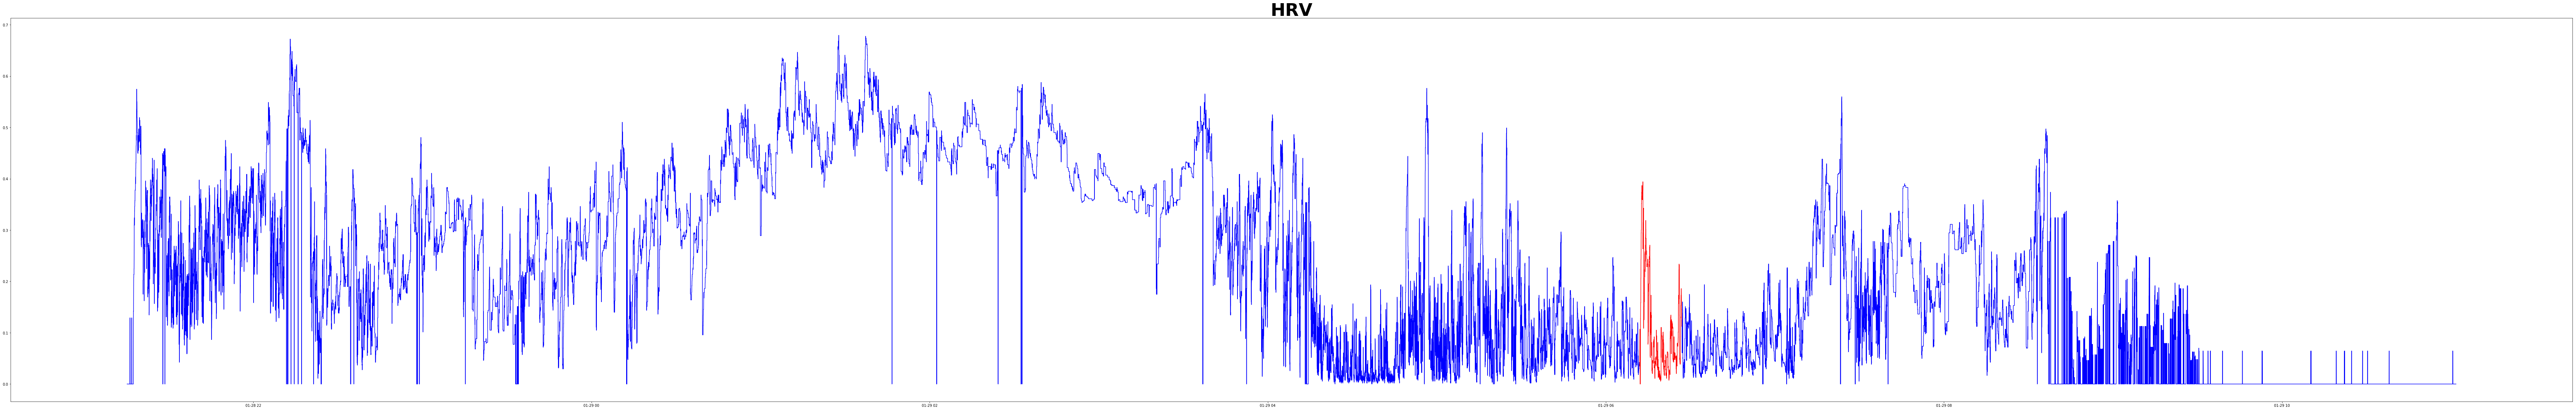

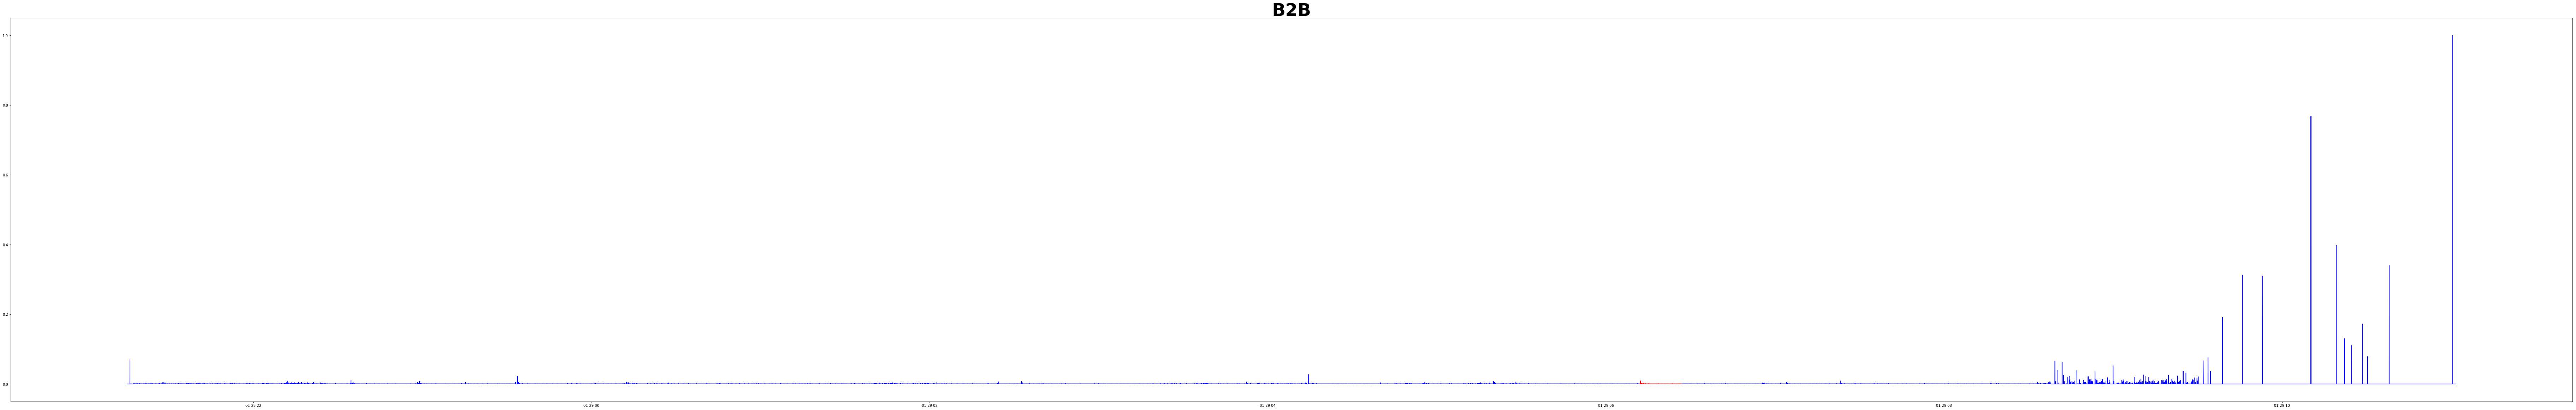

In [41]:
font = {'fontsize': 50,
 'fontweight' : 'bold'}

plt.figure(figsize=(130,20))
plt.plot(no_crisis_antes.DateTime,no_crisis_antes.HR,c='b')
plt.plot(crisis.DateTime,crisis.HR,c='r')
plt.plot(no_crisis_despues.DateTime,no_crisis_despues.HR,c='b')
plt.title('HR',fontdict=font)

plt.figure(figsize=(130,20))
plt.plot(no_crisis_antes.DateTime,no_crisis_antes.RR,c='b')
plt.plot(crisis.DateTime,crisis.RR,c='r')
plt.plot(no_crisis_despues.DateTime,no_crisis_despues.RR,c='b')
plt.title('RR',fontdict=font)

plt.figure(figsize=(130,20))
plt.plot(no_crisis_antes.DateTime,no_crisis_antes.SV,c='b')
plt.plot(crisis.DateTime,crisis.SV,c='r')
plt.plot(no_crisis_despues.DateTime,no_crisis_despues.SV,c='b')
plt.title('SV',fontdict=font)

plt.figure(figsize=(130,20))
plt.plot(no_crisis_antes.DateTime,no_crisis_antes.HRV,c='b')
plt.plot(crisis.DateTime,crisis.HRV,c='r')
plt.plot(no_crisis_despues.DateTime,no_crisis_despues.HRV,c='b')
plt.title('HRV',fontdict=font)

plt.figure(figsize=(130,20))
plt.plot(no_crisis_antes.DateTime,no_crisis_antes.B2B,c='b')
plt.plot(crisis.DateTime,crisis.B2B,c='r')
plt.plot(no_crisis_despues.DateTime,no_crisis_despues.B2B,c='b')
plt.title('B2B',fontdict=font)

### PCA de las constantes vitales

In [56]:
from tsnecuda import TSNe as PCA

def analisis(datos):
    data = datos.iloc[:,1:len(datos.columns)-1]
    clf = PCA(n_components=2).fit(data)

    
    return clf

def _dibuja(X,Y,ax,c,alpha=1):
    ax.scatter(X,Y,c=c,s=3,alpha=alpha)

def dibuja(datos,clasificador,t=True,figure=None, ax=None,c='r'):
    data = datos.iloc[:,1:len(datos.columns)-1]
    
    pcaT = clasificador.transform(data)
    
    if figure is None:
        figure, ax = plt.subplots(nrows=1,ncols=1,figsize=(24,24))
        
    target = datos['target'].values
    notTarget = np.logical_not(target)

    serie = pd.DataFrame(pcaT)

    X = pd.Series(serie[0]).loc[notTarget]
    Y = pd.Series(serie[1]).loc[notTarget]

    X_t = pd.Series(serie[0]).loc[target]
    Y_t = pd.Series(serie[1]).loc[target]
    
    if t:
        _dibuja(X_t,Y_t,ax,c)
    else:
        c = '#0971B2'
        _dibuja(X,Y,ax,c,alpha=0.5)

    return figure, ax



ImportError: cannot import name 'TSNe'

(<Figure size 1728x1728 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff5e84ae860>)

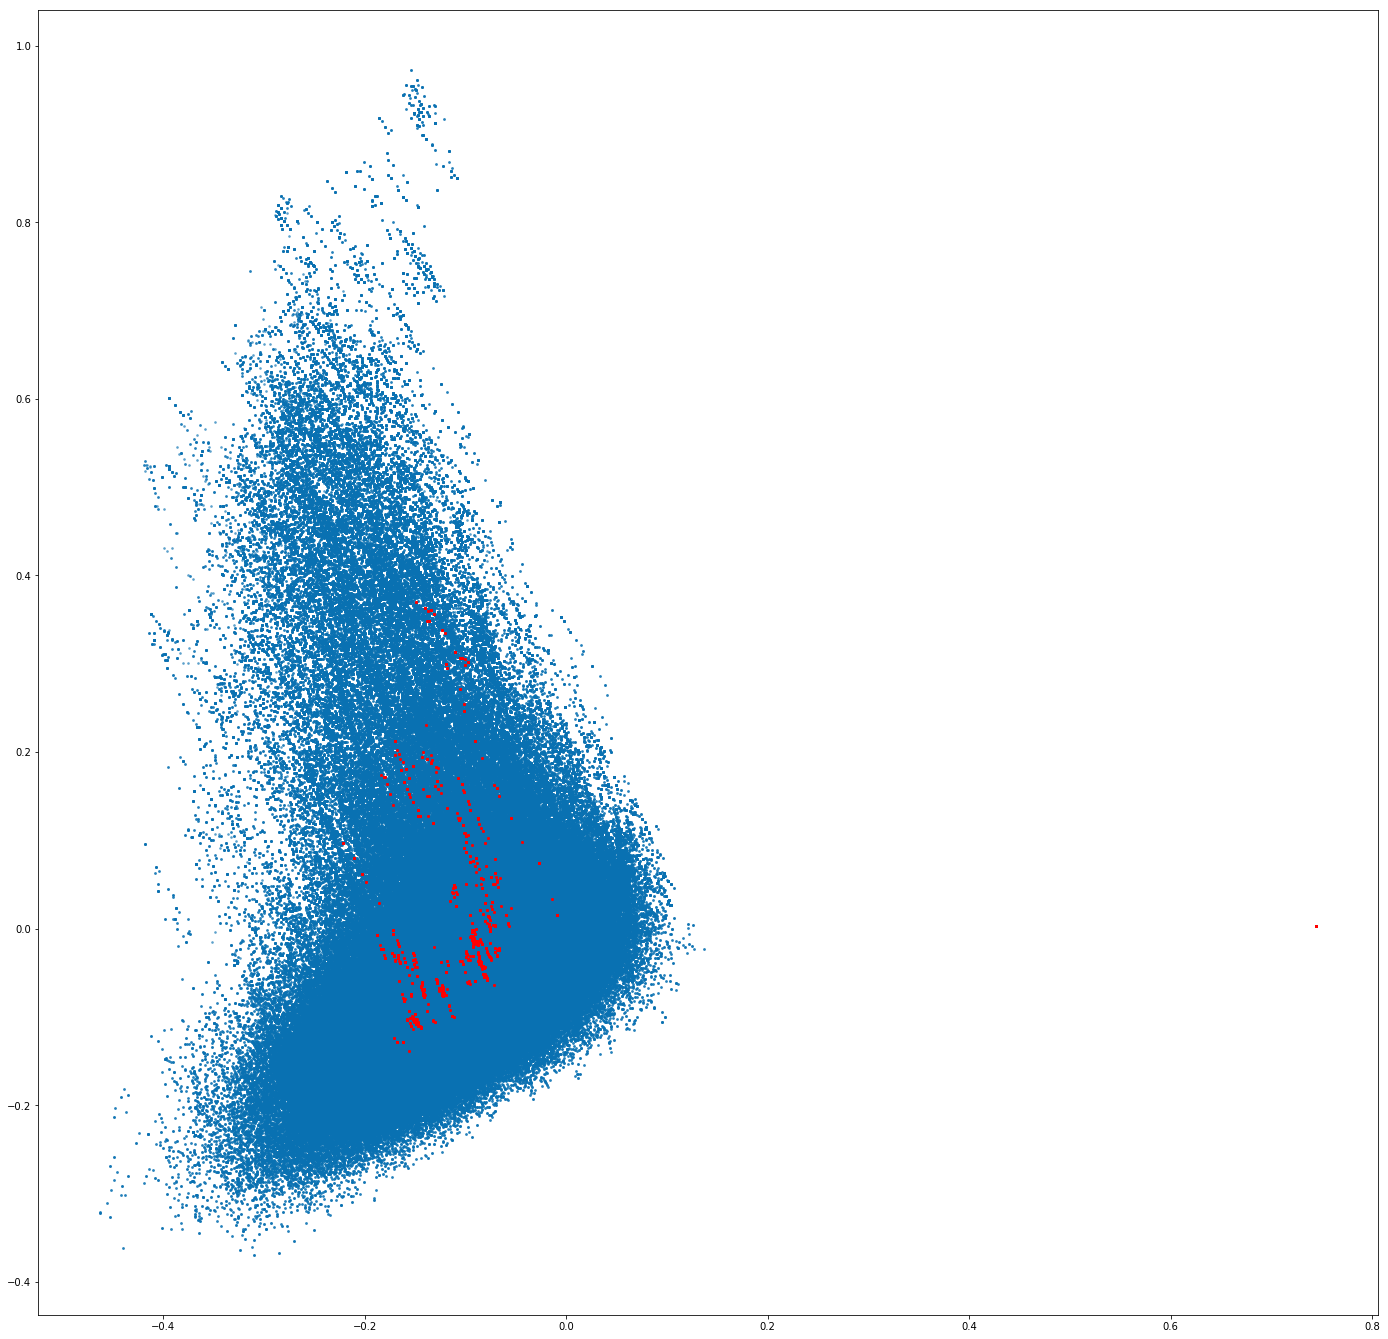

In [54]:
clf = analisis(datos_pre)
fig,ax = dibuja(datos_pre,clf,False)
dibuja(datos_pre,clf,True,fig,ax)
